## Functions and Imports

In [1]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
import random
from onix.analysis.fitter import Fitter
import onix.models.hyperfine as hyperfine
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from onix.analysis.functions.shared import *
from onix.analysis.functions.lf_ramsey_shared import *
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import *

#### Useful Functions: 
plot_antihole(data_number, linear_term = False, errorbars = True, plot = True, note = None, fitted_freq_offset = np.inf, fitted_amp_difference = np.inf, chi_cutoff = np.inf)\
    - Plots an antihole with or without linear term and cutoffs for bad fits\
    - Note: This plots transmission/monitor$_\mathrm{before}$ - transmission/monitor$_\mathrm{after}$. To see this in terms of OD, use optical_antihole_check


plot_antihole_multi(data_number, linear_term = False, errorbars = True, plot = True, note = None, fitted_freq_offset = np.inf, fitted_amp_difference = np.inf, chi_cutoff = np.inf)\
    - Plots the antiholes for one full Ramsey fringe starting at data_number

histogram_slopes(data_range, max, bins = 30, plot = True, title = None)\
    - Fits antiholes with linear terms and histograms the slopes. Returns slopes_E_pos, slopes_E_neg

antihole_SNR_over_time(data_range, max, linear_term = False, errorbars = False, plot = True, title = None, note = None)\
    - Fit antiholes and plot the SNR in the fitted amplitudes over time

plot_ramsey(data, get_results, do_average = True)\
     - Plots ramsey phase scan given the data dictionary

analyze_data(data_range, max, get_results, ignore_data_numbers = [], load_old = True, save_new = True)\
    - same analysis code as before, but hidden in a different file


### Antihole SNR Fluctuations

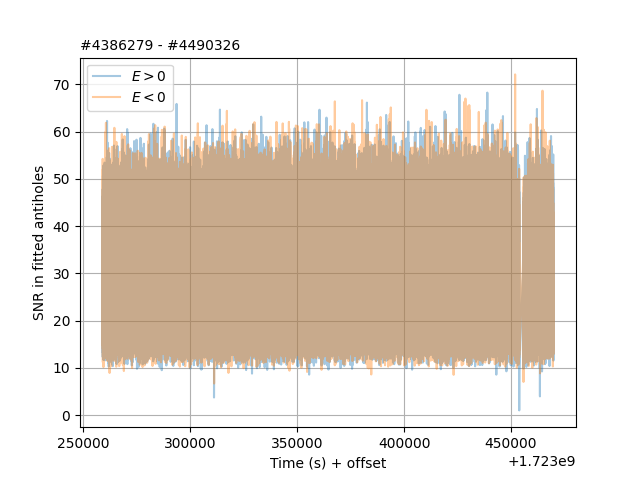

In [3]:
times_E_pos, times_E_neg, SNR_E_pos, SNR_E_neg = antihole_SNR_over_time((4386279, 4386279+7), 4490326)

In [6]:
path_to_save = "/home/icarus/Documents/data/manual/2024_08/15/snr_over_time.npz"
np.savez(path_to_save,times_E_pos = times_E_pos, times_E_neg = times_E_neg, SNR_E_pos = SNR_E_pos, SNR_E_neg = SNR_E_neg)

In [33]:
loaded_data = np.load(path_to_save, allow_pickle = True)
times_E_pos = loaded_data["times_E_pos"]
times_E_neg = loaded_data["times_E_neg"]
SNR_E_pos = loaded_data["SNR_E_pos"]
SNR_E_neg = loaded_data["SNR_E_neg"]

In [42]:
SNR_E_pos1 = np.array(SNR_E_pos[0:len(SNR_E_pos) // 2])
times_E_pos1 = np.array(times_E_pos[0:len(times_E_pos ) // 2])
SNR_E_neg1 = np.array(SNR_E_neg[0:len(SNR_E_neg) //2])
times_E_neg1 = np.array(times_E_neg[0: len(times_E_neg) // 2])

SNR_E_pos2 = np.array(SNR_E_pos[len(SNR_E_pos) // 2:])
times_E_pos2 = np.array(times_E_pos[len(times_E_pos ) // 2:])
SNR_E_neg2 = np.array(SNR_E_neg[len(SNR_E_neg) //2:])
times_E_neg2 = np.array(times_E_neg[len(times_E_neg) // 2:])

In [7]:
package_size = 8

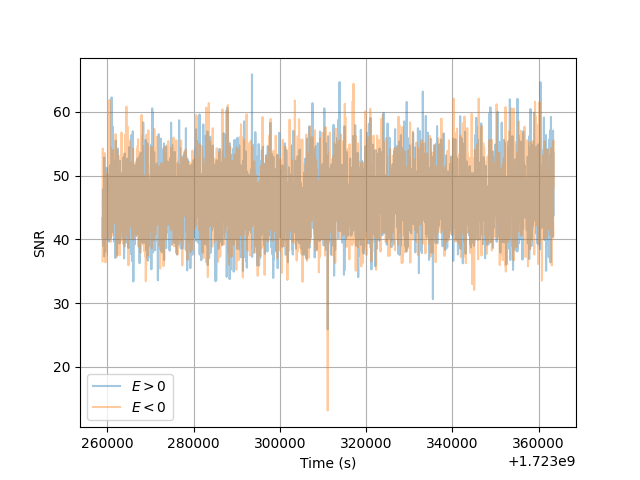

In [25]:
fig, ax = plt.subplots()
ax.plot(times_E_pos[0::package_size], snr_E_pos[0::package_size], alpha = 0.4, label = "$E>0$")
ax.plot(times_E_neg[0::package_size], snr_E_neg[0::package_size], alpha = 0.4, label = "$E<0$")

# pred = []
# for i in times_E_pos:
#     pred.append(20* np.sin(2*np.pi*f[np.argmax(norm_squared_fft)] * i) + 40)   
#ax.plot(times_E_pos, pred)

ax.set_xlabel("Time (s)")
ax.set_ylabel("SNR")
ax.grid()
ax.legend()
plt.show()

E>0 	 Maximum: 0.00030613636185468194 Hz = 3266.5182075779812 s
E<0 	 Maximum: 0.00030613636185468194 Hz = 3266.5182075779812 s


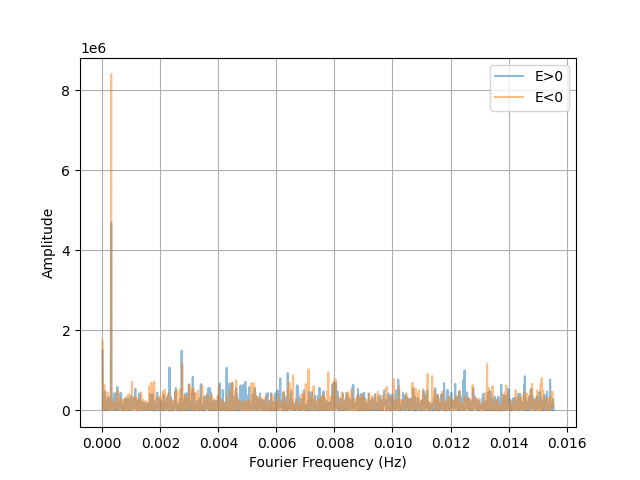

In [50]:
delta_t_neg = np.mean(np.diff(times_E_neg1[0::package_size]))
fft_E_neg = np.fft.fft(SNR_E_neg1[0::package_size])
n_neg = len(SNR_E_neg1) // package_size
frequencies_neg = np.fft.fftfreq(n+1, delta_t_neg)
f_mask_neg = frequencies_neg > 0
f_neg = frequencies_neg[f_mask_neg]
fft_E_neg = fft_E_neg[f_mask_neg]
norm_squared_fft_neg = 2*np.abs(fft_E_neg)**2

delta_t_pos = np.mean(np.diff(times_E_pos1[0::package_size]))
fft_E_pos = np.fft.fft(SNR_E_pos1[0::package_size])
n_pos = len(SNR_E_pos1) // package_size
frequencies_pos = np.fft.fftfreq(n+1, delta_t_pos)
f_mask_pos = frequencies_pos > 0
f_pos = frequencies_pos[f_mask_pos]
fft_E_pos = fft_E_pos[f_mask_pos]
norm_squared_fft_pos = 2*np.abs(fft_E_pos)**2

fig, ax = plt.subplots()
ax.plot(f_pos, norm_squared_fft_pos, label = "E>0", alpha = 0.5)
ax.plot(f_neg, norm_squared_fft_neg, label = "E<0", alpha = 0.5)
ax.set_xlabel("Fourier Frequency (Hz)")
ax.set_ylabel("Amplitude")
ax.legend()
ax.grid()

print(f"E>0 \t Maximum: {f[np.argmax(norm_squared_fft_pos)]} Hz = {1/f[np.argmax(norm_squared_fft_pos)]} s") 
print(f"E<0 \t Maximum: {f[np.argmax(norm_squared_fft_neg)]} Hz = {1/f[np.argmax(norm_squared_fft_neg)]} s") 
# All data E>0 3348.51185675152 s; first half of data E>0 3266.5182075779812 s; second half of data E >0 3326.881143538796 s

ValueError: x and y must have same first dimension, but have shapes (30,) and (31,)

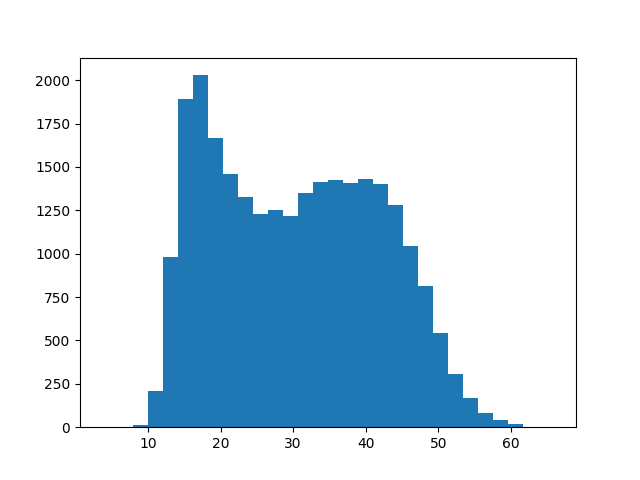

In [52]:
fig, ax = plt.subplots()
x, y ,_ = ax.hist(SNR_E_pos1, bins = 30)
x = 
ax.plot(x,y)
plt.show()

## Plot Ramsey

A = 0.088(3) 
C = 0.1415(19) 
phi_0 = 0.18(3) 
A = 0.089(3) 
C = 0.1434(19) 
phi_0 = 0.18(3) 


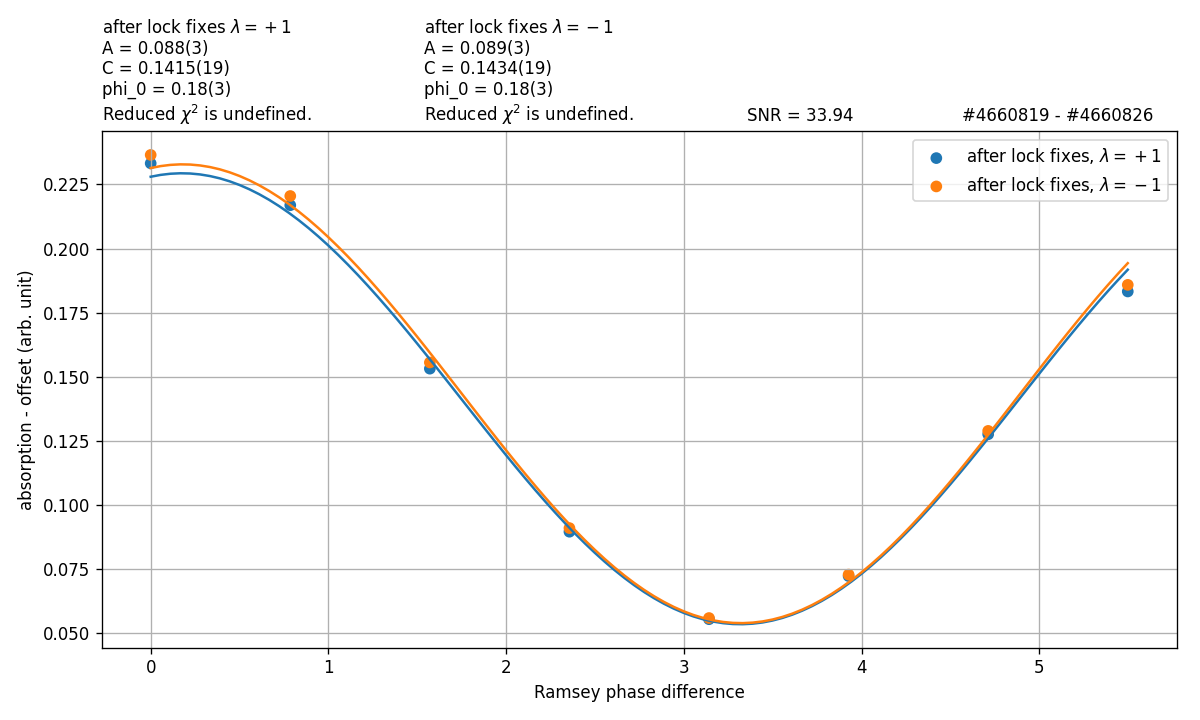

SNR with 9 phase points = 33.94406115507791


In [127]:
data = {
    #"256 repeats": (2555562 , 2555961),
    #"64 repeats": (2555962, 2556361),
    #"16 repeats": (2556362 , 2556761),
    #"test": (2678062 +4, 2678065+4),
    #"temp":(4620280, 4620287),
    #"temp":(4625350, 4625353),
    "after lock fixes":(4660819, 4660826)
}

plot_ramsey(data, get_results, do_average = True)

## long term phase scan

In [13]:
## Old experiment data numbers
# data_range = (3055958 , 3055958 + 7)
# max = 3073350

# data_range = (4048762, 4048769)
# max = 4050193

# data_range = (4084103, 4084103+8)
# max = 4084363

# August 7 - 8 overnight
# data_range = (4242552, 4242559)
# max = 4321239

# 1.1 MHz stark splitting. Fit without linear term
# data_range = (4343578, 4343585)
# max = 4379537

# 2 MHz splitting with 5 MHz chasms
# data_range = (4385377, 4385384)
# max = 4386104

#2 MHz splitting with 2.5 MHz chasms
# data_range = (4386203, 4386210)
# max = 4386258

# back to 5 MHz chasm
# data_range = (4386279, 4386286)
# max = 4490326

# correct 1.1 MHz Data
# data_range = (4496091, 4496098)
# max = 4507402

#axion run changed RF offset 
# data_range = (4530349, 4530349 + 7)
# max = 4543952


###############################################################

##### short time

# test with cb optical mirror
# data_range = (4544758, 4544765)
# max = 4545557

# null without cb mirror
# data_range = (4545558, 4545565)
# max = 4546357

##### for a longer time (~ 1h)

# test with cb optical mirror
# data_range = (4546464, 4546471)
# max = 4554463

# null without cb mirror
# data_range = (4554616, 4554623)
# max = 4562615

###############################################################

### overnight cb detuning perturb test

# -19 MHz
# data_range = (4562879, 4562886)
# max = 4572478

# -18.5 MHz
# data_range = (4572479, 4572486)
# max = 4582078

# -18 MHz
# data_range = (4582079, 4582086)
# max = 4591678

# -17.5 MHz
# data_range = (4591679, 4591686)
# max = 4601278

# -17 MHz
# data_range = (4601279, 4601286)
# max = 4610878

###############################################################3
# chasm run with different E fields
# data_range = (4511113, 4511113+7)
# max = 4528392

# 1.1 MHz-- attempt to reproduce measurement of W_T = 0
# data_range = (4611050, 4611057)
# max = 4612945

#another attempt of the above
# data_range = (4613004, 4613011)
# max = 4613611

###############################################################
# OPTIMIZING STATE PREPARATION PARAMETERS
# data_range = (4614612, 4614619)
# max = 4614771

In [92]:
# Test
# data_range = (4625431, 4625434)
# max = 4654432 #4625562

######### chasm, no mirror
data_range = (4657576, 4657583)
max = 4659175

######### no chasm, no mirror
data_range = (4659176, 4659183)
max = 4660775



results, col_indices = analyze_data(data_range, max, get_results, ignore_data_numbers = [4653391, 4653392])

In [93]:
np.max(results[:,col_indices["end_time"]])

1723760215.003239

In [94]:
start_time = 0 #1723576426
start_mask = results[:, col_indices["start_time"]] > start_time

a_mask = results[:, col_indices["state"]] == "a"
b_mask = results[:, col_indices["state"]] == "b"

E_fields = np.unique(results[:, col_indices["field_plate_amplitude"]])
E_masks = [results[:, col_indices["field_plate_amplitude"]] == kk for kk in E_fields]

rf_amplitudes = np.unique(results[:, col_indices["rf_amplitude"]])
rf_amplitude_masks = [results[:, col_indices["rf_amplitude"]] == kk for kk in rf_amplitudes]

rf_durations = np.unique(results[:, col_indices["rf_duration_ms"]])
rf_duration_masks = [results[:, col_indices["rf_duration_ms"]] == kk for kk in rf_durations]

durations = np.unique(results[:, col_indices["pulse_time_ms"]])
duration_masks = [results[:, col_indices["pulse_time_ms"]] == kk for kk in durations]

E_pos_mask = results[:, col_indices["E"]] == True
E_neg_mask = results[:, col_indices["E"]] == False

start_times_a = results[a_mask, col_indices["start_time"]]
start_times_b = results[b_mask, col_indices["start_time"]]
f_p_a = results[a_mask, col_indices["f+"]]
f_m_a = results[a_mask, col_indices["f-"]]
f_p_b = results[b_mask, col_indices["f+"]]
f_m_b = results[b_mask, col_indices["f-"]]

Z_a = results[a_mask, col_indices["Z"]]
Z_b = results[b_mask, col_indices["Z"]]
W_T_a = results[a_mask, col_indices["W_T"]]
W_T_b = results[b_mask, col_indices["W_T"]]

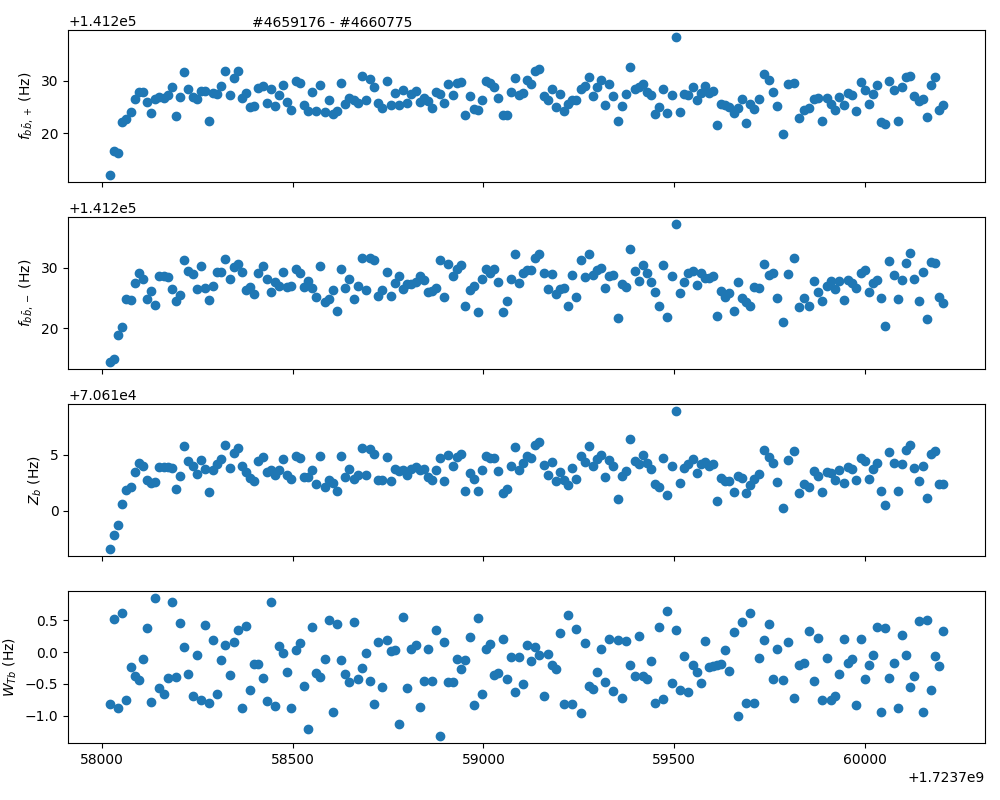

f_b,+ = 141226.7(2) Hz
f_b,- = 141227.3(2) Hz
Δf(b; D=±1 ,E=+1) = -0.47(3) Hz
W_T_b = -0.20(3) Hz


In [95]:
errorbar_args = {"fmt": "o", "ls": "none"}

masks = {}
if not np.all(a_mask == False):
    masks["a"] = a_mask
if not np.all(b_mask == False):
    masks["b"] = b_mask

cols = len(masks) * 4
fig, axs = plt.subplots(cols, 1, sharex=True, figsize=(10, cols*2))
for ll, mask_name in enumerate(masks):
    mask = masks[mask_name]
    E_pos = E_pos_mask[mask]
    E_neg = E_neg_mask[mask]
    
    axs[ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, +}$ (Hz)")
    axs[len(masks) + ll].set_ylabel("$f_{" + mask_name + "\\bar{" + mask_name + "}, -}$ (Hz)")
    axs[len(masks) * 2 + ll].set_ylabel("$Z_" + mask_name + "$ (Hz)")
    axs[len(masks) * 3 + ll].set_ylabel("$W_{T" + mask_name + "}$ (Hz)")
    for kk, d in enumerate(
        [
            results[mask, col_indices["f+"]],
            results[mask, col_indices["f-"]],
            results[mask, col_indices["Z"]],
            results[mask, col_indices["W_T"]]
        ]
    ):
        axs[kk * len(masks) + ll].errorbar(
            results[mask, col_indices["start_time"]], unumpy.nominal_values(d), unumpy.std_devs(d) * 0,
            **errorbar_args
        )
        # axs[kk * len(masks) + ll].axvline(start_time, color = "red")
axs[0].text(0.2, 1.02, f'#{data_range[0]} - #{max}', transform = axs[0].transAxes)
plt.tight_layout()
plt.show()
mask = masks["b"]
E_pos = E_pos_mask[mask]
E_neg = E_neg_mask[mask]
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("Δf(b; D=±1 ,E=+1) =", present_float(np.average(unumpy.nominal_values(W_T_b[E_pos])), np.average(np.std(unumpy.nominal_values(W_T_b[E_pos]))) / np.sqrt(len(W_T_b[E_pos]))), "Hz")
print("W_T_b =", present_float(np.average(unumpy.nominal_values(W_T_b)), np.average(np.std(unumpy.nominal_values(W_T_b))) / np.sqrt(len(W_T_b))), "Hz")

In [96]:
duration = np.max(results[:, col_indices["start_time"]][start_mask]) - np.min(results[:, col_indices["start_time"]][start_mask])
E_pos = E_pos_mask[mask][start_mask]
E_neg = E_neg_mask[mask][start_mask]

W_tb_unc = np.average(np.std(unumpy.nominal_values(W_T_b[start_mask]))) / np.sqrt(len(W_T_b[start_mask]))
Ncycle = len(results)

print(f'#{data_range[0]} - #{max}')
print(f"Time: {duration:.1f} s")
print(f"Cycle time: {duration / Ncycle:.1f} s")
print(f"{W_tb_unc / np.sqrt(3600 / duration):.3f} Hz sqrt(hr)")
print(f"N_cycle = {Ncycle}")
print(f"W_T_unc per cycle = {W_tb_unc*np.sqrt(Ncycle):.2f} Hz")
print("f_b,+ =", present_float(np.average(unumpy.nominal_values(f_p_b)), np.average(np.std(unumpy.nominal_values(f_p_b))) / np.sqrt(len(f_p_b))), "Hz")
print("f_b,- =", present_float(np.average(unumpy.nominal_values(f_m_b)), np.average(np.std(unumpy.nominal_values(f_m_b))) / np.sqrt(len(f_m_b))), "Hz")
print("W_T =", present_float(np.average(unumpy.nominal_values(W_T_b)), W_tb_unc, 2), "Hz")
print("W_T / uncertainty =", round(np.average(unumpy.nominal_values(W_T_b))/ W_tb_unc, 2))
# get_cycle_snr(5)

#4659176 - #4660775
Time: 2185.2 s
Cycle time: 10.9 s
0.025 Hz sqrt(hr)
N_cycle = 200
W_T_unc per cycle = 0.45 Hz
f_b,+ = 141226.7(2) Hz
f_b,- = 141227.3(2) Hz
W_T = -0.203(32) Hz
W_T / uncertainty = -6.38


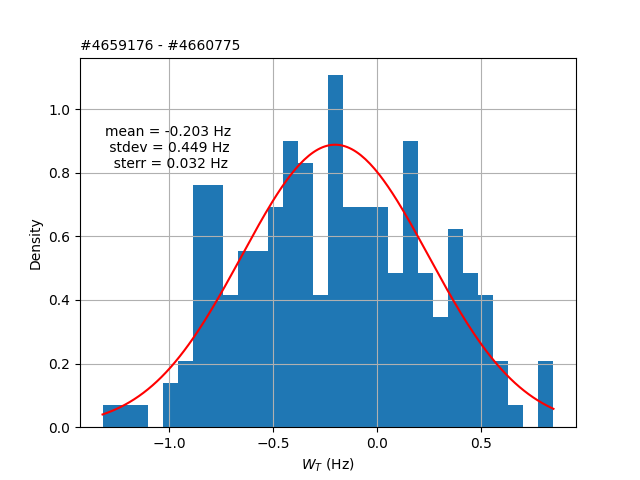

average =  -0.20269699495112928
stdev =  0.4493399283845085
sterr =  0.031773131041856355


In [97]:
to_hist = unumpy.nominal_values(W_T_b[start_mask])
to_hist_avg = np.average(to_hist)
to_hist_std = np.std(to_hist)
gaussian_x = np.linspace(np.min(to_hist), np.max(to_hist), 200)
gaussian_y = 1/(to_hist_std*np.sqrt(2*np.pi)) * np.exp(-0.5*((gaussian_x-to_hist_avg)/to_hist_std)**2)
fig, ax = plt.subplots()
ax.hist(to_hist, bins = 30, density=True)
ax.plot(gaussian_x, gaussian_y, color='red')
ax.grid()
ax.set_xlabel("$W_T$ (Hz)")
ax.set_ylabel("Density")
ax.text(0, 1.02, f'#{data_range[0]} - #{max}', transform = ax.transAxes)
ax.text(0.05,0.7, f"mean = {round(to_hist_avg, 3)} Hz \n stdev = {round(to_hist_std, 3)} Hz \n  sterr = {round(to_hist_std/np.sqrt(Ncycle), 3)} Hz", transform = ax.transAxes)

plt.show()
print("average = ", to_hist_avg)
print("stdev = ", to_hist_std)
print("sterr = ", to_hist_std/np.sqrt(Ncycle))

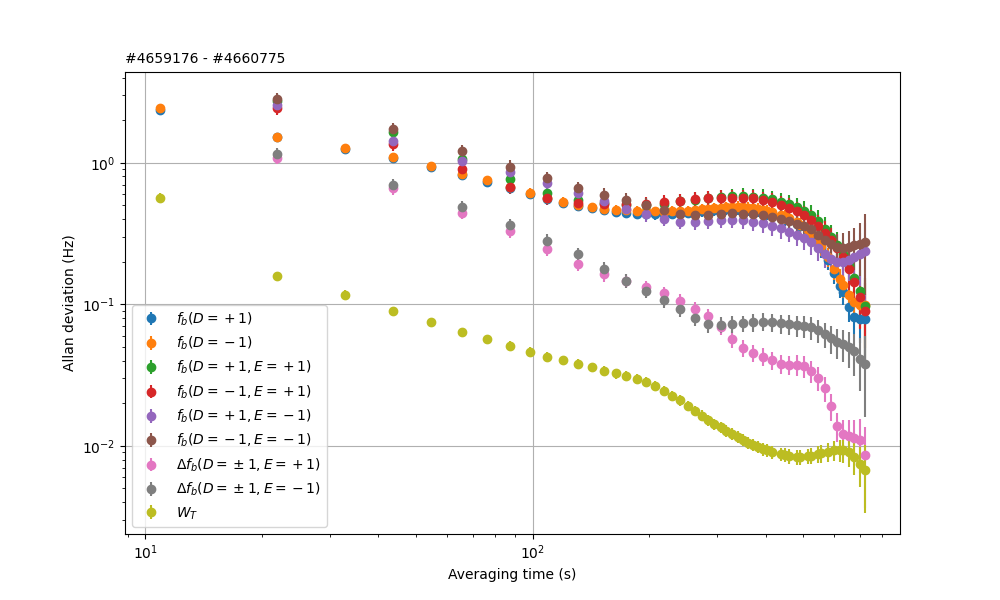

In [98]:
times = results[:, col_indices["start_time"]].astype(float)
taus = np.logspace(0, np.log10(len(times)) * 3, 500)
total_time = times[-1] - times[0]

allan_variables = [
    ("$f_b (D=+1)$", unumpy.nominal_values(results[:, col_indices["f+"]])),
    ("$f_b (D=-1)$", unumpy.nominal_values(results[:, col_indices["f-"]])),
    ("$f_b (D=+1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f+"]])),
    ("$f_b (D=-1, E=+1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == True, col_indices["f-"]])),
    ("$f_b (D=+1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f+"]])),
    ("$f_b (D=-1, E=-1)$", unumpy.nominal_values(results[results[:, col_indices["E"]] == False, col_indices["f-"]])),
    (
        "$\\Delta f_b (D=\\pm1, E=+1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == True, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == True, col_indices["f-"]]
        )
    ),
    (
        "$\\Delta f_b (D=\\pm1, E=-1)$",
        unumpy.nominal_values(
            results[results[:, col_indices["E"]] == False, col_indices["f+"]]
            - results[results[:, col_indices["E"]] == False, col_indices["f-"]]
        )
    ),
    ("$W_T$", unumpy.nominal_values(results[:, col_indices["W_T"]])),
]
step_sizes = [total_time / len(kk[1]) for kk in allan_variables]

fig, ax = plt.subplots(figsize=(10, 6))
for kk, (label, variable) in enumerate(allan_variables):
    try:
        real_taus, allan, allan_err, _ = mdev(variable, data_type="freq", taus=taus)
        real_taus *= step_sizes[kk]
        ax.errorbar(real_taus, allan, allan_err, label=label, ls="none", fmt="o")
    except:
        print("Cannot plot ", label)
        continue
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
ax.set_xlabel("Averaging time (s)")
ax.set_ylabel("Allan deviation (Hz)")
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()

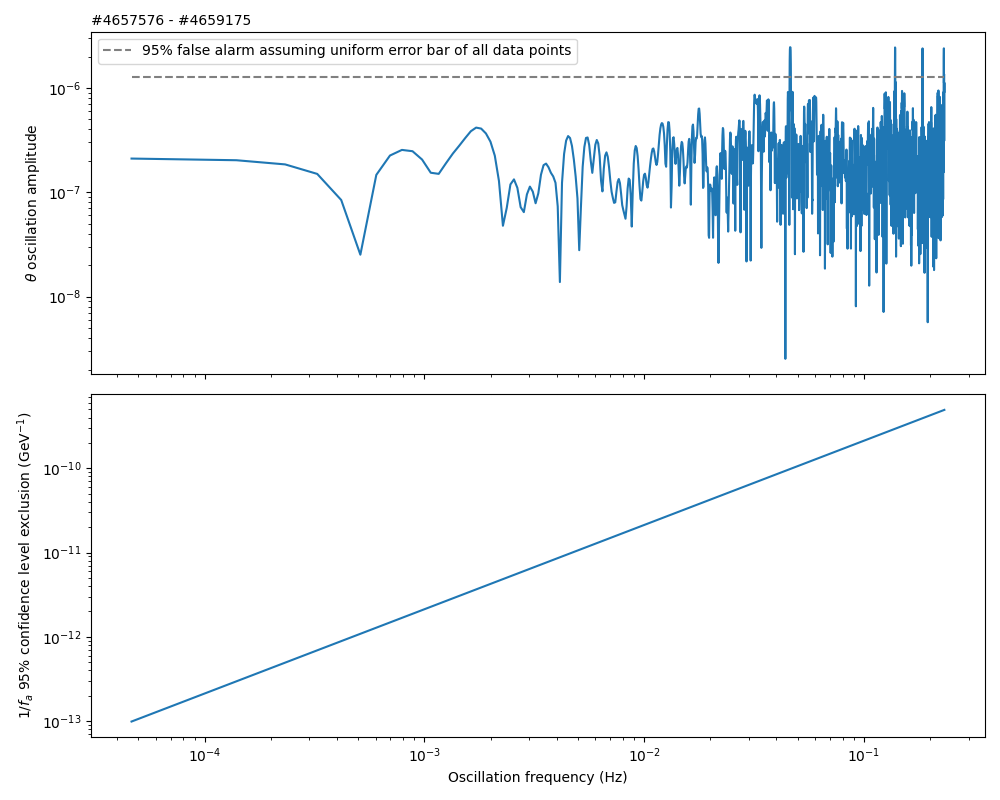

In [54]:
W_T_to_theta = 2.5e-5
# https://electricatoms.wordpress.com/2024/07/11/t-violation-measurement-from-lf-spectroscopy/
thetas = unumpy.nominal_values(results[:, col_indices["W_T"]])[start_mask] * W_T_to_theta
times = results[:, col_indices["start_time"]].astype(float)[start_mask]

theta_uncs = np.std(thetas) * np.ones(len(thetas))  # assuming error bar is std of the data for every point
ls = LombScargle(times, thetas, theta_uncs, normalization="psd")
fs, f_thetas_psd = ls.autopower()
f_thetas_amplitude_normalized = np.sqrt(f_thetas_psd / (len(f_thetas_psd) / 4))
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
f_thetas_amplitude = f_thetas_amplitude_normalized * np.std(thetas)
# https://docs.astropy.org/en/stable/timeseries/lombscargle.html#psd-normalization-unnormalized

confidence = 0.95
f_thetas_limit_psd = ls.false_alarm_level(1 - confidence)
f_thetas_limit_amplitude = np.sqrt(f_thetas_limit_psd / (len(f_thetas_psd) / 4)) * np.std(thetas)
# same normalization as above

inverse_fa_limits = inverse_fa_limit(fs, f_thetas_limit_amplitude * np.ones(len(fs)))

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
ax[0].plot(fs, f_thetas_amplitude)
ax[0].hlines([f_thetas_limit_amplitude], np.min(fs), np.max(fs), color="gray", ls="--", label=f"{confidence*100:.0f}% false alarm assuming uniform error bar of all data points")
ax[0].set_ylabel("$\\theta$ oscillation amplitude")
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax[0].transAxes)
ax[0].legend()

ax[1].plot(fs, inverse_fa_limits)
ax[1].set_xlabel("Oscillation frequency (Hz)")
ax[1].set_ylabel(f"$1 / f_a$ {confidence*100:.0f}% confidence level" + " exclusion (GeV$^{-1}$)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
plt.tight_layout()
plt.show()


In [28]:
times = (results[:, col_indices["start_time"]][start_mask][1:] - results[:, col_indices["start_time"]][start_mask][:-1])

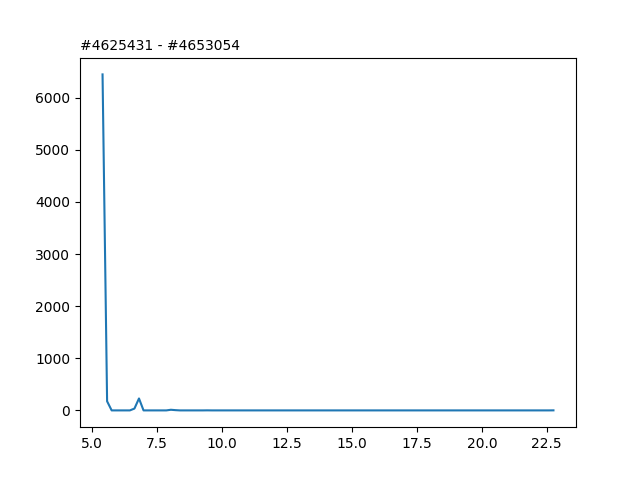

In [29]:
hist, x = np.histogram(times, bins=100)
fig, ax = plt.subplots()
ax.plot(x[1:], hist)
ax.text(0,1.02, f"#{data_range[0]} - #{max}", transform = ax.transAxes)
plt.show()